In [2]:
import glob
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
files = [f for f in glob.glob("./res/**", recursive=True) if not f.endswith("/")]
files.sort()
last_file = files[-1]
print(last_file)

./res/1578069266_w.svg


In [4]:
# for proper file
last_file = "./res/1577816830.tsv"
print(last_file)

./res/1577816830.tsv


In [5]:
mapping = {
    's': {
        's': 500000,
        'l': 3000000,
    },
    'v': {
        'u': -1,
        'r': 5,
    },
    'w': {
        's': 3,  # (x3)
        'l': 9,  # (x3)
    }

}

In [6]:
df = pd.read_csv(last_file,sep="\t",header=0)

In [7]:
new_df = [[
            "s", "v", "w", "l_format",
            "time_min","time_avg","time_max",
            "cpu_min","cpu_avg","cpu_max",
            "mem_min","mem_avg","mem_max"
]]
for ps in mapping['s']:
    for pv in mapping['v']:
        for pw in mapping['w']:
            for l_format in ['csv', 'csv.gz', 'snappy.parquet']:
                tmp_df = df.loc[
                            (df['s'] == ps) &
                            (df['v'] == pv) &
                            (df['w'] == pw) &
                            (df['l_format'] == l_format)
                        ]
                tmp_row = [
                    ps,
                    pv,
                    pw,
                    l_format,
                    round(np.min(tmp_df['time']),2),
                    round(np.mean(tmp_df['time']),2),
                    round(np.max(tmp_df['time']),2),
                    round(np.min(tmp_df['cpu']),2),
                    round(np.mean(tmp_df['cpu']),2),
                    round(np.max(tmp_df['cpu']),2),
                    int(np.ceil(np.min(tmp_df['memory'])/1024/1024)),
                    int(np.ceil(np.mean(tmp_df['memory'])/1024/1024)),
                    int(np.ceil(np.max(tmp_df['memory'])/1024/1024)),
                ]
                new_df.append(tmp_row)
                
new_df = pd.DataFrame(new_df[1:],columns=new_df[0])

In [8]:
translate_xticks = {
    's': {
        's': 'mała',
        'l': 'duża',
    },
    'v': {
        'r': 'ustalona',
        'u': 'dowolna',
    },
    'w': {
        's': 'mała',
        'l': 'duża',
    }
}

./res/1577816830_s.svg


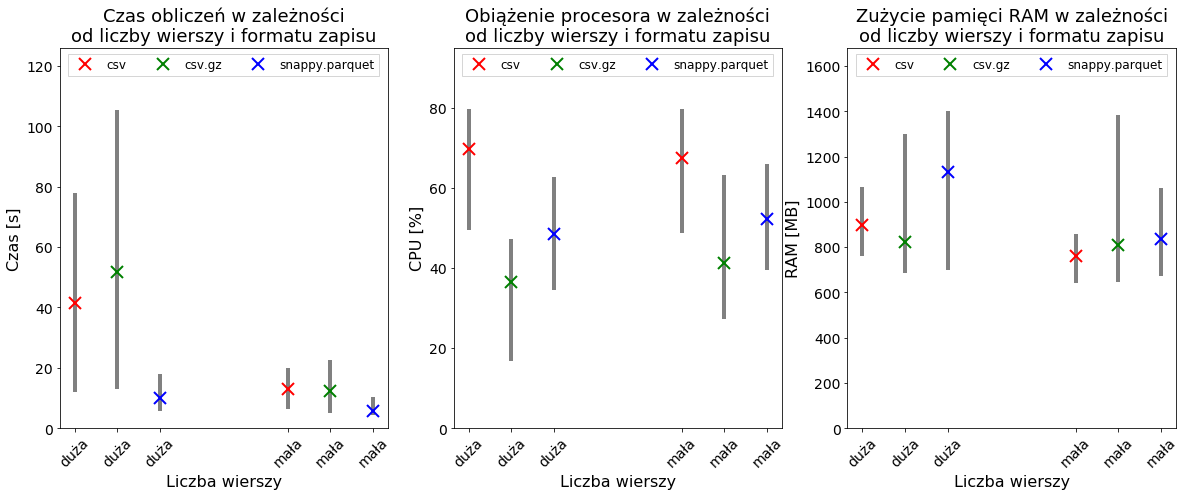

./res/1577816830_v.svg


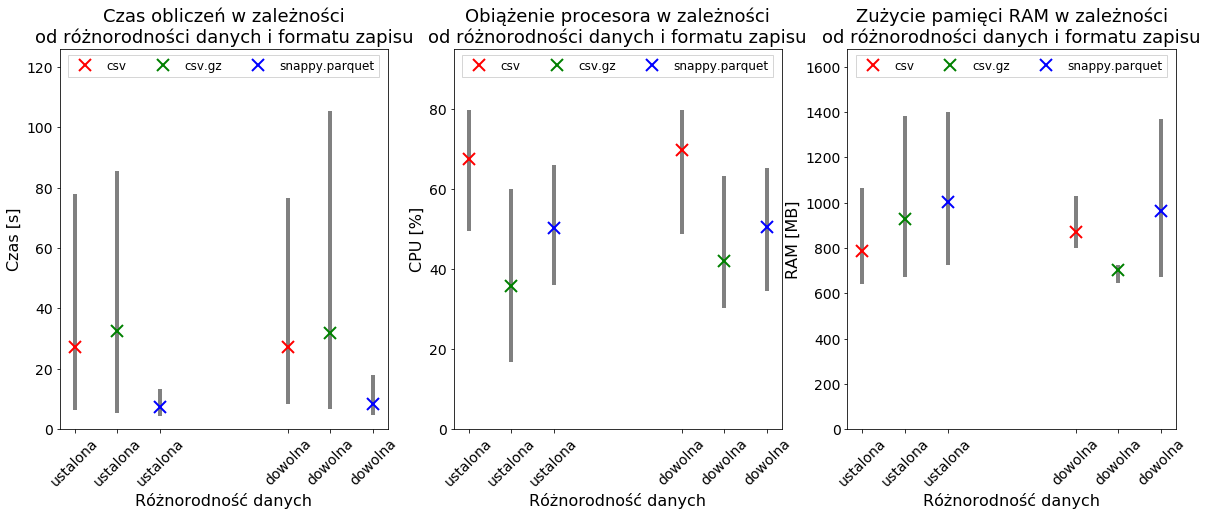

./res/1577816830_w.svg


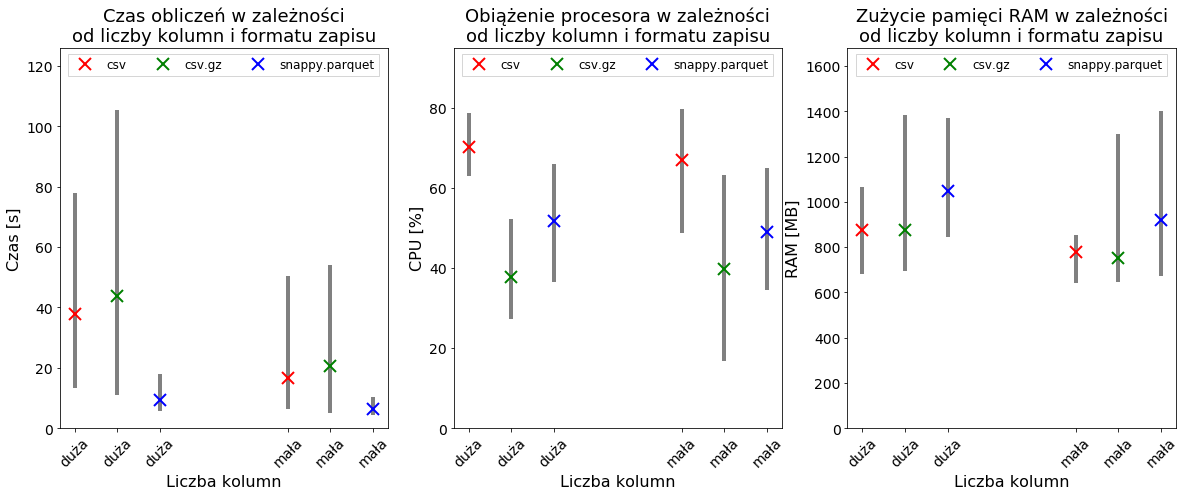

In [9]:
plot_all_comb = [
    ['s','liczby wierszy','Liczba wierszy'],
    ['v','różnorodności danych','Różnorodność danych'],
    ['w','liczby kolumn','Liczba kolumn']
]

for w_var,w_tit,w_xlab in plot_all_comb:
    chart_df = new_df.groupby([w_var,"l_format"]).agg(
        {
            "time_min":"min",
            "time_avg":"mean",
            "time_max":"max",
            "cpu_min":"min",
            "cpu_avg":"mean",
            "cpu_max":"max",
            "mem_min":"min",
            "mem_avg":"mean",
            "mem_max":"max",
        })
    chart_df = chart_df.reset_index()
    chart_df =  chart_df.sort_values(by=[w_var, 'l_format'])
    plt_xticks = chart_df[w_var].tolist()
    plt_xticks = [translate_xticks[w_var][e] for e in plt_xticks]
    plt_xformats = chart_df['l_format'].unique()
    plt_xformats.sort()
    colors= ['r','g','b']
    xd = 5

    fig, ax = plt.subplots(1, 3,figsize=(20, 7))

    plot_all_dim = [
        [
            'time',
            f"Czas obliczeń w zależności\nod {w_tit} i formatu zapisu",
            w_xlab,
            "Czas [s]"
        ],
        [
            'cpu',
            f"Obiążenie procesora w zależności\nod {w_tit} i formatu zapisu",
            w_xlab,
            "CPU [%]"
        ],
        [
            'mem',
            f"Zużycie pamięci RAM w zależności\nod {w_tit} i formatu zapisu",
            w_xlab,
            "RAM [MB]"
        ]
    ]
    for idx, (what,tit,xlab,ylab) in enumerate(plot_all_dim):

        draw_tmp = [
            [l_for,[f'{what}_min',f'{what}_avg',f'{what}_max']] for l_for in plt_xformats
            ]

        plt_xticks_x = list(range(len(draw_tmp)))
        plt_xticks_x.extend([el+xd for el in plt_xticks_x])
        tmp_y_max = 0
        for xx,(ff,cols) in enumerate(draw_tmp):
            mins = chart_df.loc[chart_df['l_format'] == ff][cols[0]]
            means = chart_df.loc[chart_df['l_format'] == ff][cols[1]]
            maxes = chart_df.loc[chart_df['l_format'] == ff][cols[2]]
            ax[idx].plot([xx,xx+xd],means,'x',ms=12,mew=2,color=colors[xx],label=ff)
            ax[idx].errorbar([xx,xx+xd], means, [means - mins, maxes - means],
                         fmt='none', ecolor='gray', lw=4)
            tmp_y_max = max(maxes.tolist() + [tmp_y_max])
        ax[idx].set_xticks(plt_xticks_x)
        ax[idx].set_xticklabels(plt_xticks,rotation=45)
        ax[idx].tick_params(labelsize=14)
        ax[idx].set_title(tit,fontsize=18)
        ax[idx].set_xlabel(xlab,fontsize=16)
        ax[idx].set_ylabel(ylab,fontsize=16)
        ax[idx].set_ylim([0,int(tmp_y_max*1.2)])
        ax[idx].legend(loc='upper center', fancybox=False, shadow=False,fontsize=12,ncol=3)
    save_path = "{}_{}.svg".format(last_file[0:-4], w_var)
    print(save_path)
    plt.savefig(save_path,format='svg',orientation='landscape',bbox_inches='tight')

    plt.show()